Removing 'Ummm's from Audio
===================

This notebook describes the process of how [the umdone project](https://github.com/scopatz/umdone) removes dreaded 'ummm's - or any other undesirable token - from an audio file.  This should be really helpful to podcasters, who typically do this by hand.  This requires a training set of data, which you might have to create.  Let's start with some imports!

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
from umdone import dtw
from IPython.display import Audio

/home/scopatz/miniconda3/lib/python3.4/site-packages/librosa/core/audio.py:33: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


First, let's assume that we have a set of 'umm's on their own. For demonstration purposes, we will only have one umm.

In [2]:
umm, sr = librosa.load('umm.wav', sr=None)
Audio(umm, rate=sr, autoplay=False)

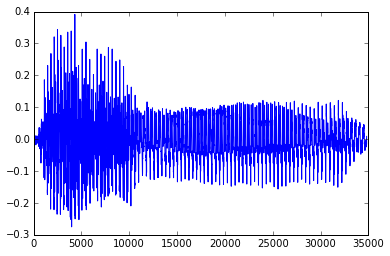

In [3]:
plt.plot(umm)

Then suppose that we have an audio file that contains some speech. This speech might include some ummms, but also has a lot of real information in it too!  The following sample starts out with "Well ummm I don't really..."

In [4]:
well, sr = librosa.load('well-umm.wav', sr=None)
Audio(well, rate=sr, autoplay=False)

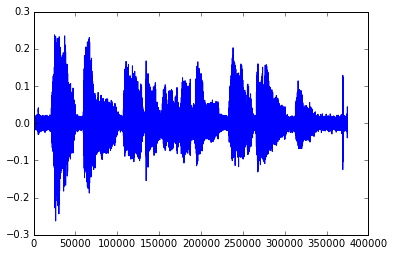

In [5]:
plt.plot(well)

Wav files have a given sample rate, `sr`, or the number or data points per second. This is important to keep track of because it defines how we deal with real time.

In [6]:
sr

44100

Word Detection
===========
The first thing that we want to do is figure out where the words are in the file. We need to do this so that we can compare individual words in the speech to the umms. We'll perform the detection by looking for silences that bound the different peaks.

The algorithm here does the following:

* splits the enitre wav into equally sized windows
* evaluates the root-mean squared of each window
* finds where the window's RMS is above a noisy threshold.

Using some numpy fancy indexing and judicious use of `np.argwhere()`, we can tease out all of the spoken boundaries.

In [7]:
window_size = int(sr*0.05)
window_size

2205

In [8]:
x = well[:-(len(well)%window_size)]
x.shape = (len(x)//window_size), window_size
window_rms = np.sqrt((x**2).sum(axis=1)/window_size)
#window_rms < 0.01
window_mask = window_rms > 0.01

`window_mask` is now a boolean array that is True when speech (and not background noise) is found. The red dots along the x-axis in the following figure represent these window indivudually.

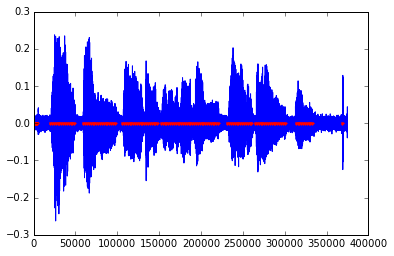

In [9]:
plt.plot(well)
for i, quiet in enumerate(window_mask):
    if not quiet:
        continue
    plt.plot([i*window_size, (i+1*window_size)], [0, 0], 'r.')

But what we really want are the bin boundaries! We want to find where there are contiguous windows of speech.  First lets get the indices where speech is occuring.

In [10]:
window_fi = np.argwhere(window_mask).flat  # fancy index
window_fi[:]

array([  2,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 167])

To find where this is contiguous, we simplely look for the place where the mask indices change by more than one.  These locations represent a boundary between speaking and not speaking.

In [11]:
window_boundary = np.argwhere((window_fi[1:] - window_fi[:-1]) > 1).flatten()
window_boundary

array([  0,  14,  32,  52,  84,  98, 115, 125])

From these, we can fine upper and lower bounds

In [12]:
window_lower = window_fi[window_boundary + 1]
window_lower

array([  9,  27,  48,  69, 105, 120, 142, 167])

In [13]:
window_upper = window_fi[window_boundary]
window_upper

array([  2,  22,  44,  67, 100, 118, 136, 151])

Of course, this is in window-space. To be useful, we need to convert back to sample- or time-space

In [14]:
time_boundries = np.array([window_lower[:-1], window_upper[1:]]).T * window_size
time_boundries

array([[ 19845,  48510],
       [ 59535,  97020],
       [105840, 147735],
       [152145, 220500],
       [231525, 260190],
       [264600, 299880],
       [313110, 332955]])

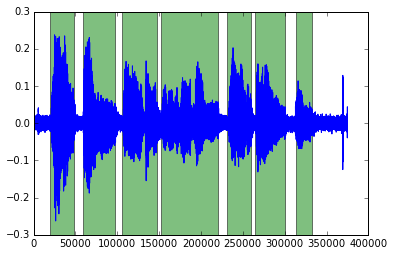

In [15]:
for u, l in time_boundries:
    plt.axvspan(u, l, facecolor='g', alpha=0.5)
plt.plot(well)

Great!  Now we can compare these words

Comparing Words to Training Data
=====================
Now we want to compare the words that we have picked out to our umm.  It turns out that comparing sounds in the time domain is really very difficult.  We can make the problem much easier by converting to a frequency domain via FFT or similar transformation.  

In fact what we are going to do is convert the audio to [Mel-frequency cepstrum coeficients or MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  This is kind of like a multi-component FFT. MFCCs are commonly used in speech recognition because they are robust to noisy systems. However, the number of compenents used is up to the user. There seems to be a sweet spot between 10 and 20.

One nice thing about MFCCs, is that there are tools that compute it for us already! Let's look at the MFCCs for our umm training data.

In [16]:
umm_mfcc = librosa.feature.mfcc(umm, sr, n_mfcc=13).T

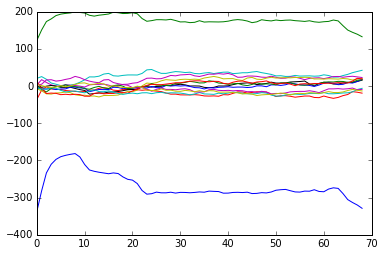

In [17]:
p = plt.plot(umm_mfcc)

Now to compare the MFCCs of two audio clips to each other we are going to use [Dynamic Time Warping or DTW](http://www.nickgillian.com/wiki/pmwiki.php?n=GRT.DTW).  [This lecure does an amazing job of explaining the concept.](http://luthuli.cs.uiuc.edu/~daf/courses/CS-498-DAF-PS/Lecture%2018%20-%20Time%20series,%20DTW.pdf) But at a high level, what it is doing is taking the L1 norm of the MFCCs and finding the miminum distance between them at each frequency.  That is, it computes how much you would have to shift one signal in order to line up with the other signal.  The noisy bits are more or less canceled out, the clips can have different lengths, and it doesn't matter if the peaks line up in time because we are doing all of this in the fequency domain!

This method computes three things: 

* a meaure of distance between the signals
* a 'cost' matrix for shifting from one signal to the other.
* a 'warp path' that is the minimial trasition between the two signals.

Let's look at theses parameters between the first word we found in our large audio file and the training umm.

In [18]:
clip = well[time_boundries[0,0]:time_boundries[0,1]]
clip_mfcc = librosa.feature.mfcc(clip, sr, n_mfcc=13).T
d, cost, w = dtw.dtw(clip_mfcc, umm_mfcc)

Distance is  109.548185414


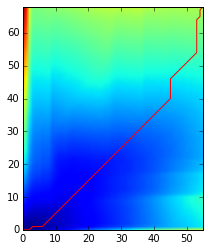

In [19]:
plt.imshow(cost.T)
plt.plot(w[0], w[1], 'r-')
plt.axis([0, w[0][-1], 0, w[1][-1]])
print('Distance is ', d)

The maximal distance is, of course, following along the sides of the space. From here, we can compute the nomralized distances for each clip to the training data.

In [20]:
dists = np.empty(len(time_boundries), dtype=float)
for i, (l, u) in enumerate(time_boundries):
    clip = well[l:u]
    #librosa.output.write_wav('clip{0}.wav'.format(i), clip, sr)
    clip_mfcc = librosa.feature.mfcc(clip, sr, n_mfcc=13).T
    d, cost, w = dtw.dtw(clip_mfcc, umm_mfcc)
    dists[i] = d / (w[0][-1] + w[1][-1])
dists

array([ 0.89063565,  0.40985375,  0.55962726,  0.47776493,  0.68053891,
        0.55900074,  0.93183753])

The umms in the clip are given by those with a sufficiently close distance.

In [21]:
threshold = 0.45
time_boundries[dists <= threshold]

array([[59535, 97020]])

Now that we know where the umms are, we can remove these and render the audio.

In [22]:
def remove_slices(arr, slices):
    if len(slices) == 0:
        return arr
    elif len(slices) == 1:
        return np.concatenate([arr[:slices[0][0]], arr[slices[0][1]:]])
    else:
        views = [arr[:slices[0][0]]]
        for (_, l), (u, _) in zip(slices[:-1], slices[1:]):
            views.append(arr[l:u])
        views.append(arr[slices[-1][1]:])
        return np.concatenate(views)

In [23]:
well_sliced = remove_slices(well, time_boundries[dists <= threshold])
Audio(well_sliced, rate=sr, autoplay=False)

Now isn't that better!